In [1]:
import numpy as np
import pandas as pd
import pickle

from isttc.scripts.cfg_global import project_folder_path
from isttc.spike_utils import get_lv

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
dataset_folder = project_folder_path + 'synthetic_dataset\\'
fig_folder = project_folder_path + 'results\\synthetic\\figures\\'
results_folder = project_folder_path + 'results\\synthetic\\results\\param_fr_alpha_tau\\'

In [3]:
save_fig = False
calculate_lv = True

### Calculate Lv

In [4]:
if calculate_lv:
    # load spike trains
    with open(dataset_folder + 'spike_trains.pkl','rb') as f:
        data_param = pickle.load(f)
    
    all_spike_trains_param = data_param['spike_trains']
    alphas_param = data_param['alphas']
    fr_values_param = data_param['fr_values']
    tau_ms_param = data_param['tau_ms']
    duration_ms_param = data_param['duration_ms']
    
    print(f'n spike trains {len(all_spike_trains_param)}, len {all_spike_trains_param[0][-1]/1000}, duration_ms {duration_ms_param}')

    # calculate Lv
    lv_param_l = []
    for spike_train in all_spike_trains_param:
        spike_train_int = np.asarray([int(spike) for spike in spike_train])
        lv = get_lv(spike_train_int, False)
        lv_param_l.append(lv)
        
    lv_df = pd.DataFrame({
        'alpha':   alphas_param,
        'fr':      fr_values_param,
        'tau_ms':  tau_ms_param,
        'lv':      lv_param_l
    })
    lv_df.insert(0,'unit_id',lv_df.index)
    
    # store Lv dataset
    lv_df.to_pickle(results_folder + 'lv_df.pkl')
    lv_df.to_csv(results_folder + 'lv_df.csv')
else:
    lv_df = pd.read_pickle(results_folder + 'lv_df.pkl')

n spike trains 100000, len 598.8243581617338, duration_ms 600000


In [5]:
# Lv is NaN when spike train has < 3 spikes
rows_with_nans_df = lv_df[lv_df.isna().any(axis=1)]
n_rows_with_nan = len(rows_with_nans_df)
print(f'N rows with NaNs {n_rows_with_nan}')

N rows with NaNs 34


### Plots

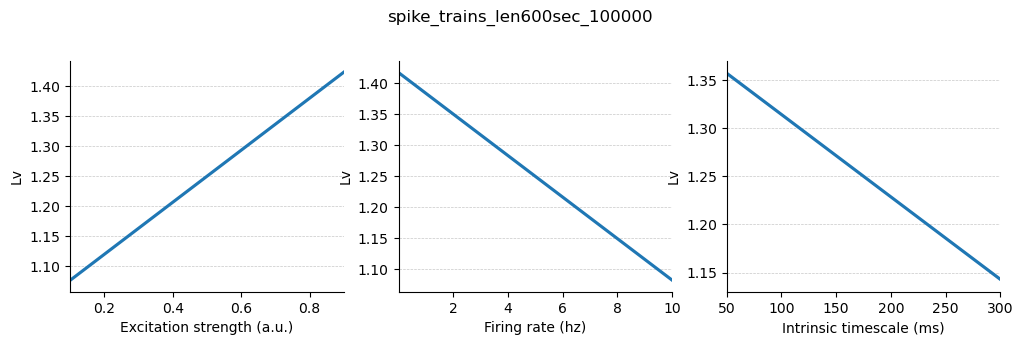

In [6]:
fig, axes = plt.subplots(1,3, figsize=(12, 3), sharey=False)

sns.regplot(x=lv_df['alpha'].values, y=lv_df['lv'].values, scatter=None, ax=axes[0])
axes[0].set_xlim([0.1, 0.9])
axes[0].set_xlabel('Excitation strength (a.u.)')

sns.regplot(x=lv_df['fr'].values, y=lv_df['lv'].values, scatter=None, ax=axes[1])
axes[1].set_xlim([0.01, 10])
axes[1].set_xlabel('Firing rate (hz)')

sns.regplot(x=lv_df['tau_ms'].values, y=lv_df['lv'].values, scatter=None, ax=axes[2])
axes[2].set_xlim([50, 300])
axes[2].set_xlabel('Intrinsic timescale (ms)')

for ax in axes.flat:
    ax.set_ylabel('Lv')
    ax.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)

sns.despine()

fig.suptitle('spike_trains_len600sec_100000', y=1.05)

if save_fig:
    plt.savefig(fig_folder + 'lv_vs_params_regplot.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'lv_vs_params_regplot.svg' , bbox_inches='tight')

1.01665143355302 1.6652347001780416


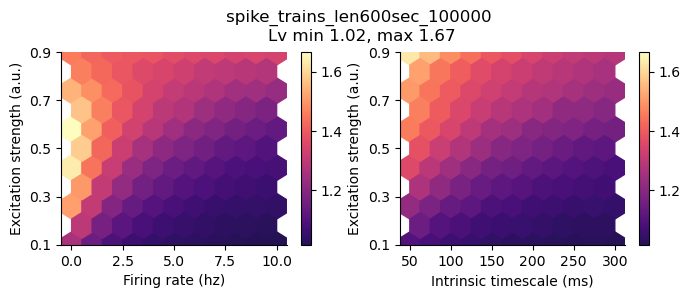

In [7]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """
    Return a new colormap based on cmap but only sampling its colors
    between minval and maxval (both in [0,1]).
    """
    new_colors = cmap(np.linspace(minval, maxval, n))
    new_cmap = LinearSegmentedColormap.from_list(
        f"{cmap.name}_trunc_{minval:.2f}_{maxval:.2f}",
        new_colors
    )
    return new_cmap


fig, axes = plt.subplots(1,2, figsize=(8,2.5))

trunc_magma = truncate_colormap(plt.cm.magma, minval=0.15, maxval=1)

hb0 = axes[0].hexbin(
    x=lv_df['fr'].values, y=lv_df['alpha'].values,
    C=lv_df['lv'].values,
    reduce_C_function=np.median,   
    gridsize=10,                
    cmap=trunc_magma,
    #norm = norm,
    mincnt=1                    
)

hb1 = axes[1].hexbin(
    x=lv_df['tau_ms'].values, y=lv_df['alpha'].values,
    C=lv_df['lv'].values,
    reduce_C_function=np.median,   
    gridsize=10,                
    cmap=trunc_magma,
    #norm = norm,
    mincnt=1                    
)

vmin = np.min([hb0.get_array().min(), hb1.get_array().min()])
vmax = np.max([hb0.get_array().max(), hb1.get_array().max()])
print(vmin, vmax)

hb0.set_clim(vmin, vmax)
hb1.set_clim(vmin, vmax)

fig.colorbar(hb0, ax=axes[0], shrink=1)
fig.colorbar(hb1, ax=axes[1], shrink=1)

axes[0].set_xlabel('Firing rate (hz)')
axes[1].set_xlabel('Intrinsic timescale (ms)')
axes[1].set_xticks(np.linspace(50, 300, 6))

fig.suptitle(f'spike_trains_len600sec_100000 \nLv min {vmin:.2f}, max {vmax:.2f}', y=1.05)

for ax in axes.flat:
    sns.despine(ax=ax)
    ax.set_ylabel('Excitation strength (a.u.)')
    ax.set_ylim([0.1, 0.9])
    ax.set_yticks(np.linspace(0.1, 0.9, 5))

if save_fig:
    plt.savefig(fig_folder + 'lv_vs_params_heatmap.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'lv_vs_params_heatmap.svg' , bbox_inches='tight')